# Fine-tune: тренировка и тест модели FNN

Чтобы улучшить точность predictions основной модели: обучим на тренировочном наборе данных корректирующую полносвязную нейронную сеть (FNN) совместно в основной моделью (Chronos Bolt base).

Корректирующая FNN будет получать на вход выход основной модели и выдавать корректирующие числа в пределах (-1; 1), которые будут умножаться для массштабирования коррекций по выбранному значению delta и прибавляться к единице. В результате будут вычисляться коэффициенты для умножения точек выхода основной модели.

Например, если мы возьмём delta = 0.6 (т.е. коррекция в пределах ± 30 %), то выходы корретирующей FNN будут означать:
* -1 — уменьшить результат на 30 %;
* 1 — увеличить результат на 30 %;
* 0 — оставить результат без изменений (не корректировать).

(На самом деле FNN не может выдать точно -1 или 1, а может выдавать значения в пределах не включая (-1; 1). Мы используем функцию активации tanh, чтобы получить эффект мягкого ограничения значений).

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from etna.analysis import plot_forecast
from etna.datasets import TSDataset
from etna.metrics import R2, SMAPE
from etna.models.nn import ChronosBoltModel
from etna.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [3]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [31]:
DELTA = 0.6  # Допустимый диапазон коррекции значений ± 30 %

DTYPE = torch.float32

set_seed(3)

torch.set_num_threads(28)
print('Threads:', torch.get_num_threads())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_default_device(DEVICE)

print(DEVICE)

Threads: 28
cuda


## Определения

In [33]:
def load_df_with_date_and_target_only(path: str) -> pd.core.frame.DataFrame:
    """Load data_time, traffic_volume and return as dataframe"""
    df = pd.read_csv(path, usecols=['date_time', 'traffic_volume'])
    df = df.reset_index()
    df = df.drop(columns=['index'])
    return df


def load_df(path: str) -> pd.core.frame.DataFrame:
    """Load data and return as dataframe"""
    df = pd.read_csv(path)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df.loc[df["holiday"].isnull(), "holiday"] = "None"
    return df


def calculate_y_to_fnn_outputs(
        df: pd.core.frame.DataFrame,
        delta: float
        ) -> pd.core.frame.DataFrame:
    """ Пересчёт y в значения ожидаемых выходов FNN """
    def process_record(rec):
        result_test = []
        for predict_val, test_val in zip(rec['test'], rec['predict']):
            raw_val = 2.0 * (test_val / predict_val - 1.0) / delta

            if raw_val > 1:
                expected_val = 1
            elif raw_val < -1:
                expected_val = -1
            else:
                expected_val = raw_val

            result_test.append(expected_val)
        rec['test'] = result_test
        return rec

    df_y = df.apply(process_record, axis=1)
    return df_y


def load_train_fnn_df(
        path: str,
        delta: float) -> tuple[torch.Tensor, torch.Tensor]:
    """Load train dataset for train FNN"""
    df = pd.read_csv(path, delimiter=";")
    df.predict = df.predict.map(lambda x: eval(x))
    df.test = df.test.map(lambda y: eval(y))
    df_fnn = calculate_y_to_fnn_outputs(df, delta)
    return torch.tensor(df_fnn["predict"]), torch.tensor(df_fnn["test"])


def show_metrics_from_etna(ts_true: TSDataset, 
                           ts_in_fact: TSDataset,
                           model_name: str):
    """Print and plot SMAPE, R² metrics and a diagram by ETNA framework"""

    def expand_string(s: str, expected_len: int) -> str:
        len_s = len(s)
        if len_s < expected_len:
            return s + " " * (expected_len - len_s)
        return s

    smape_etna_func = SMAPE(mode="macro")
    smape_etna = smape_etna_func(y_true=ts_true, y_pred=ts_in_fact)
    
    message_SMAPE = f"Average SMAPE for {model_name}: "
    message_R2 = f"Average R² for {model_name}: "
    message_len = max(len(message_R2), len(message_SMAPE))
    message_SMAPE = expand_string(message_SMAPE, message_len)
    message_R2 = expand_string(message_R2, message_len)

    print(f"{message_SMAPE}{smape_etna / 100.:.3f}")
    r2_etna_func = R2(mode="macro")
    r2_etna = r2_etna_func(y_true=ts_true, y_pred=ts_in_fact)
    print(f"{message_R2}{r2_etna:.3f}")
    plot_forecast(forecast_ts=ts_in_fact, test_ts=ts_true)


def add_y_predict_to_df(df: pd.core.frame.DataFrame,
                        y_predict: list,
                        title: str):
    df["traffic_volume_"+title] = y_predict


def df_to_etna_ts(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    df["segment"] = "metro"
    df_processed = df.rename(
        columns={"date_time":"timestamp", "traffic_volume":"target"}
    )
    return TSDataset(df=TSDataset.to_dataset(df_processed), freq="h")

## Dataset

В <a href="3.2.Fine-tune_render_train_data.ipynb">3.2.Fine-tune_render_train_data.ipynb</a> описано сохранение тренировочного набора данных для FNN в файл fnn_train.csv. Теперь загрузим тренировочный набор данных: процедура загрузки пересчитает значения тестовой колонки в пределы [-1; 1] в соответствии с выбранной DELTA коррекции. 

Также, разделим тренировочный набор данных на тренировочную и валидационную составляющую.

После этого перейдем к обучению корректирующей FNN.

In [6]:
X, y = load_train_fnn_df("fnn_train.csv", DELTA)

y.unsqueeze_(1)

print(X)
print(y)

tensor([[1239.7178,  697.2615,  439.5862,  ..., 2953.0608, 2687.5989,
         2126.2510],
        [1203.5508,  658.9670,  432.0527,  ..., 3090.9524, 2826.6172,
         2240.8223],
        [1174.8503,  655.2458,  431.5723,  ..., 3048.5156, 2797.9265,
         2209.3633],
        ...,
        [1134.5382,  673.0093,  457.1218,  ..., 2444.3545, 2484.0640,
         1960.5801],
        [ 741.5854,  438.3550,  347.3760,  ..., 2473.4521, 2318.4136,
         1774.2953],
        [1144.3523,  660.2661,  471.0051,  ..., 2435.3862, 2405.3811,
         1930.8695]], device='cuda:0')
tensor([[[ 0.0875,  0.1565,  1.0000,  ...,  0.2396,  0.8530,  1.0000]],

        [[-1.0000, -0.9510, -0.2886,  ..., -0.0257,  0.1968,  0.2821]],

        [[-0.2786,  0.0217, -0.0186,  ...,  0.2447,  0.6694,  0.5164]],

        ...,

        [[ 0.2411,  1.0000,  1.0000,  ..., -0.0949,  0.3256,  0.8029]],

        [[-0.5989, -0.4795,  0.6733,  ..., -0.1996,  0.1667,  0.0992]],

        [[ 0.6947,  0.8271,  1.0000,  ...,  

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=1)

## Определяем модель FNN

In [84]:
def init_model(n):  # n — число нейронов в слое
    """
    Функция создания модели
    
    Args:
        n (int): The first number.

    Returns:
        tuple: model, criterion, optimizer
    """
    model = CorrectionModel(n)
    criterion = loss_MSE
    optimizer = optim.AdamW(model.parameters(), lr=0.001)  # lr=0.01

    return model, criterion, optimizer


class CorrectionModel(nn.Module):
    """ Корректирующая FNN """

    def __init__(self, input_output_size):
        super(CorrectionModel, self).__init__()

        hidden_size = 256

        self.fc1 = nn.Linear(input_output_size, hidden_size, dtype=DTYPE)
        self.act1 = torch.nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, input_output_size, dtype=DTYPE)

    def forward(self, x):
        """ Predict """
        x = self.act1(self.fc1(x))
        x = self.act1(self.fc2(x))
        return x

    def get_metric(model, X_val, y_val):
        """ Get calculated MSE metric """
        y_val_pred = model.forward(X_val)

        mse = loss_MSE(y_val_pred, y_val).detach().numpy()
        return mse


# если метрика не улучшилась больше чем на level
#  на протяжении последних 5ти эпох,
# то нейросеть уже дошла до своего предела,
# так считаем, и останавливаем обучение сети.
# verbose_only — параметр для отладки,
# когда выводится информация, а реальной остановки не делается
def is_stop(mse_list, level=0.005, mseLevel=0.001, verbose_only=False):
    """ Train stop condition """

    if len(mse_list) >= 5 and mse_list[-1] <= mseLevel:
        n = 4
        events = 0

        if verbose_only:
            print('——————————————')

        for i in range(-n - 1, -1):
            if abs(mse_list[-1] - mse_list[i]) / mse_list[i] < level:
                if verbose_only:
                    print(mse_list[-1],
                          mse_list[i],
                          abs(mse_list[-1] - mse_list[i]) / mse_list[i])
                else:
                    events = events + 1

        if events == n:
            return True

    return False


def loss_MSE(pred, target):
    """ Calculate MSE """
    squares = torch.pow(pred - target, 2)
    mse = squares.cpu().mean()
    return mse


def do_train(
        model,
        criterion,
        optimizer,
        num_epochs,
        stop_level,
        mse_level,
        X_train,
        y_train,
        X_val,
        y_val):
    """ Train procedure """

    mse_list = []
    for epoch_index in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        mse_list.append(model.get_metric(X_val, y_val))

        # if epoch_index % 300 == 0:
        # isStop(mse_list, level=stopLevel, verbose_only=True)

        if is_stop(mse_list, level=stop_level, mseLevel=mse_level):
            break

    print('Обучение нейронной сети завершено.')
    print("MSE по валидац. выборке: {:.3f}"
          .format(model.get_metric(X_val, y_val)))

    # print(mse_list)
    return mse_list


def draw_results_of_train(model, mse_list):
    """ Draw results of train """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(mse_list, lw=3)
    ax.set_title("Training metric by validation dataset", size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show()


def calculate_fnn_output(y_pred_fnn, delta, y_pred_base):
    """ Calculate final FNN output """

    result = []
    koef_list = [1 - y * delta / 2.0 for y in y_pred_fnn]

    for k, y in zip(koef_list, y_pred_base):
        result.append(y * k)

    return result

## Тренируем модель FNN

100%|██████████| 100/100 [00:00<00:00, 162.76it/s]

Обучение нейронной сети завершено.
MSE по валидац. выборке: 0.155


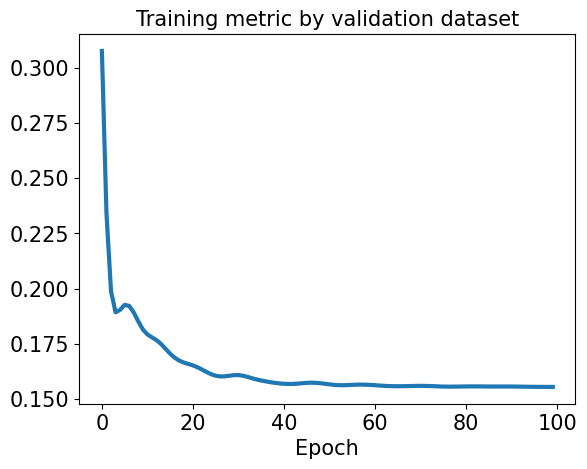

In [ ]:
num_epochs = 100  # Число эпох
stop_level = 0.01  # Критерий остановки обучения
mse_level = 0.1  # Требуемый уровень ошибки MSE

model_fnn, criterion, optimizer = init_model(336)

mse_list = do_train(
    model_fnn,
    criterion,
    optimizer,
    num_epochs,
    stop_level,
    mse_level,
    X_train,
    y_train,
    X_val,
    y_val
    )

draw_results_of_train(model_fnn, mse_list)

## Проверяем общий результат на тестовом наборе данных

In [ ]:
def predict_finetuned_model(
        pipeline_model_base: Pipeline,
        model_corrector: CorrectionModel,
        ts: TSDataset) -> TSDataset:
    """ Predict procedure for fine-tuned combined model """

    torch.set_default_device('cpu')
    ts_predict_bolt = pipeline_model_base.forecast(ts)
    df_etna_chronos_bolt_predict = ts_predict_bolt.df
    column_timestamp = pd.Series(df_etna_chronos_bolt_predict.index)
    
    y_predict_chronos_bolt_base = list(
        df_etna_chronos_bolt_predict["metro"]["target"]
    )

    input_fnn = torch.tensor(y_predict_chronos_bolt_base,
                             device=DEVICE)
    
    print(model_corrector.eval()) # Переводим модель в режим inference
    with torch.no_grad():
        y_predict_fnn = model_corrector.forward(input_fnn).cpu()

    fnn_output = calculate_fnn_output(y_predict_fnn.numpy()[:336],
                                  DELTA,
                                  y_predict_chronos_bolt_base)
    df_predict_fnn = pd.DataFrame()
    df_predict_fnn["timestamp"] = column_timestamp
    df_predict_fnn["target"] = fnn_output
    ts_predict_fnn = df_to_etna_ts(df_predict_fnn)
    return ts_predict_bolt, ts_predict_fnn

In [68]:
torch.set_default_device('cpu')

In [69]:
path_to_chronos_bolt_model = "H:\\Инструменты\\Windows\\GPT or another LLM\
\\amazon chronos-bolt-base 2024"

HORIZON = 24 * 14
TRAIN_SIZE = 24 * 90

metrics = [SMAPE(), R2()]

Загрузим наборы данных.

In [70]:
df_train = load_df_with_date_and_target_only(
    "Metro_Interstate_Traffic_Volume_train.csv"
)
df_test = load_df_with_date_and_target_only(
    "Metro_Interstate_Traffic_Volume_test.csv"
)

In [71]:
ts = df_to_etna_ts(df_train)

Подготовим основную модель: Chronos Bolt base.

In [72]:
model_chronos_bolt = ChronosBoltModel(
    path_or_url=path_to_chronos_bolt_model,
    encoder_length=TRAIN_SIZE
)

pipeline_etna_bolt = Pipeline(
    model=model_chronos_bolt,
    horizon=HORIZON,
    transforms=[]
)

Выполним predict комбинированной fine-tuned модели Chronos Bolt base + FNN:
- ts_predict_bolt — ответ Chronos Bolt base (используем ниже для сравнительных графиков);
- ts_predict_fnn — скорректированный с помощью FNN финальный ответ.

In [77]:
ts_predict_bolt, ts_predict_fnn = predict_finetuned_model(pipeline_etna_bolt,
                                                          model_fnn,
                                                          ts)

CorrectionModel(
  (fc1): Linear(in_features=336, out_features=256, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=256, out_features=336, bias=True)
)


Запишем результаты в общий файл predicts экспериментов, чтобы вывести на общем сравнительном графике в конце notebook <a href="3.Modeling.ipynb">3.Modeling.ipynb</a>.

In [83]:
path_results_predict = ".\\Metro_Interstate_Traffic_Volume_predicts.csv"
df_predicts = load_df(path_results_predict)

add_y_predict_to_df(
    df_predicts,
    list(ts_predict_fnn.df["metro"]["target"]) + [None,],
    "finetuned_bolt_plus_fnn"
)

df_predicts.to_csv(path_results_predict, index=False)

Выведем метрики и сравнительные графики: Chronos Bolt base и комбинированная fine-tuned модель.

Average SMAPE for Fine-tuned Chronos Bolt base + FNN: 0.071
Average R² for Fine-tuned Chronos Bolt base + FNN:    0.982
Average SMAPE for Chronos Bolt base: 0.091
Average R² for Chronos Bolt base:    0.977


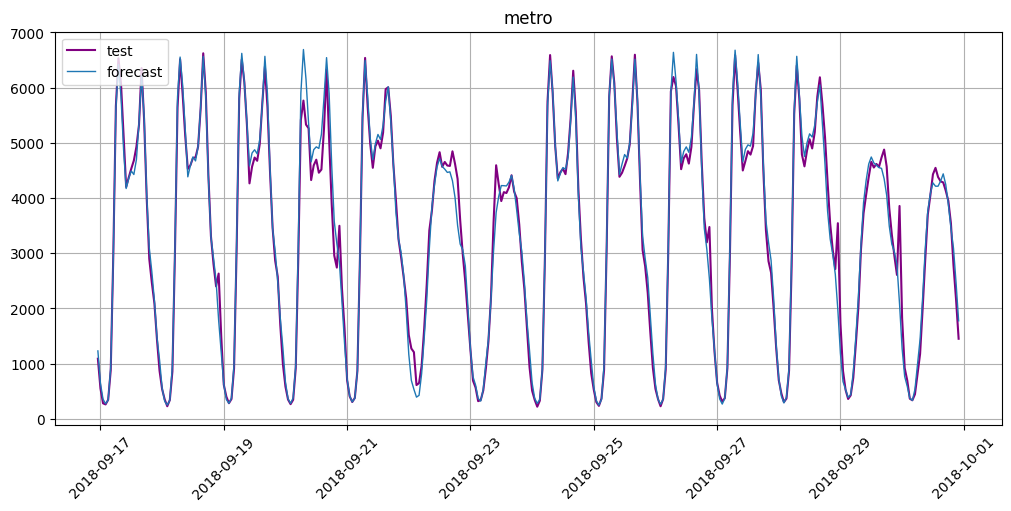

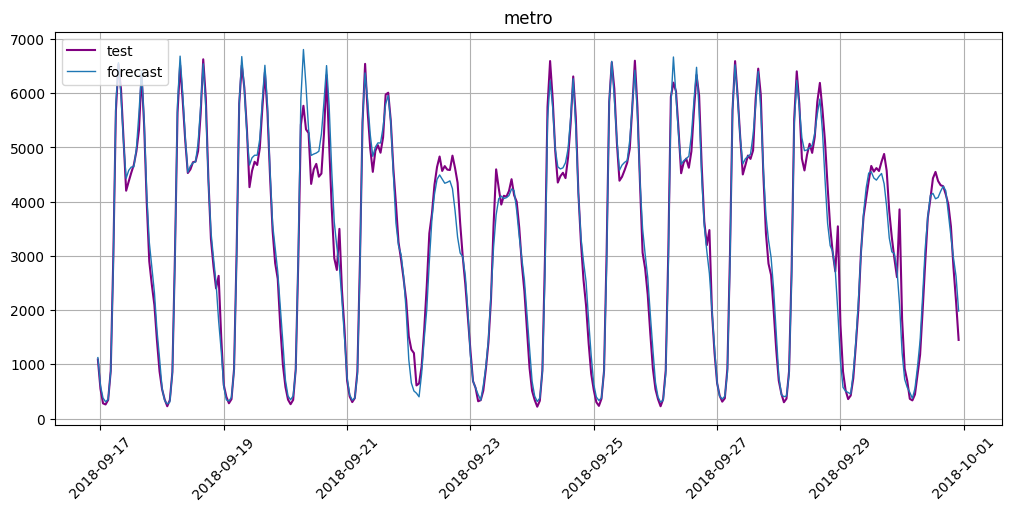

In [85]:
ts_test = df_to_etna_ts(df_test.loc[:336-1])  # Chronos Bolt выдаёт на одну точку меньше, чем в тесте
show_metrics_from_etna(ts_test, ts_predict_fnn, "Fine-tuned Chronos Bolt base + FNN")
show_metrics_from_etna(ts_test, ts_predict_bolt, "Chronos Bolt base")

Комбинированная модель дала, в среднем, более точный ответ, чем базовая.